In [1]:
#imports!
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import plot_partial_dependence, permutation_importance
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import plot_confusion_matrix
%load_ext autoreload
%autoreload 2
print("we workin'!")

we workin'!


In [2]:
def varimax(Phi, gamma = 1, q = 20, tol = 1e-6):
    """Varimax is for Rotated Principal Component Analysis. Given a matrix (of loadings) Phi, 
    find an expression of the subspace spanned by Phi that maximizes the variance of the squared loadings.
    Basically rotate Phi so that there are a lot of zero weights and it's easier to understand.
    """
    from numpy import eye, asarray, dot, sum, diag
    from numpy.linalg import svd
    p,k = Phi.shape
    R = eye(k)
    d=0
    for i in range(q):
        d_old = d
        Lambda = dot(Phi, R)
        u,s,vh = svd(dot(Phi.T,asarray(Lambda)**3 - (gamma/p) * dot(Lambda, diag(diag(dot(Lambda.T,Lambda))))))
        R = dot(u,vh)
        d = sum(s)
        if d/d_old < tol: 
            print(i) 
            break
    return dot(Phi, R), R

def show_matrix(mat, ax=None, **kwargs):
    """Convenience function for plotting a matrix"""
    if not 'cmap' in kwargs.keys():
        kwargs['cmap']= plt.cm.bwr
    if not ax:
        fig, ax = plt.subplots(figsize=(8,8))
    else:
        fig = ax.figure
    ax.matshow(mat.T, **kwargs)
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            c = mat[i,j]
            ax.text(i, j, f'{c:0.2f}', va='center', ha='center')
    return fig, ax
    
    
def show_loadings(loadings, yticks=None, ax=None, **kwargs):
    """Convenience function for plotting a loading, just matrix with labeled ticks"""
    fig, ax = show_matrix(loadings, ax=ax,**kwargs)
    ax.set_xticks(range(loadings.shape[0]))
    ax.set_xticklabels([f'PC{i+1}' for i in range(loadings.shape[0])])
    if yticks:
        ax.set_yticks(range(len(yticks)))
        ax.set_yticklabels(yticks)
    return ax

# Part 1: Data preprocessing: Train/Val split, normalization, PCA and rotation

In [5]:
# initial loading of all train/validation data. Not loading any test data as this notebook is for model development and tuning.

all_sep_df = pd.DataFrame()
for year in ['2014', '2015']:#, '2016']:
    savefile = f'/home/disk/eos4/jkcm/Data/MEASURES/beta_data/classified_df_final.SEP_{year}_4.pickle'
    temp_df = pickle.load(open(savefile, 'rb'))
    all_sep_df = pd.concat([all_sep_df, temp_df], ignore_index=True)
    
    
vars_to_use = ['MERRA2_sfc_div', 'MERRA2_div_700', 'MERRA2_SST', 'MERRA2_EIS', 'MERRA2_LTS', 'MERRA2_RH_700', 
               'MERRA2_WSPD_10M', 'MERRA2_PS', 'MERRA2_TQV', 'MERRA2_T2M', 'MERRA2_M', 'MERRA2_T_adv', 'MERRA2_T_700']  # these are the variables to train on
var_labels = ['Sfc. div.', '700mb div', 'SST', 'EIS', 'LTS', '700mb RH', '10m wspd.' ,'Sfc. pres.', 'Col. Q$_V$', '2m T', 'MCAO idx', 'T$_{adv}$', '700mb T']
labels={0: 'Closed-cellular MCC', 1: 'Clustered cumulus', 2: 'Disorganized MCC',
        3: 'Open-cellular MCC', 4: 'Solid Stratus', 5: 'Suppressed Cu'}
train_subset = all_sep_df[vars_to_use + ['low_cf', 'cat', 'lat']].copy()  # including two different y variables.

# screening out known problems in data
# MERRA2_T_adv (*86400) should be ~-5 to 5 K/day or so. Some values are much bigger
# So we will remove all rows with abs(T_adv)>5 k/day.
train_subset.loc[np.abs(train_subset['MERRA2_T_adv'].values*86400)>5, 'MERRA2_T_adv'] = np.nan
train_subset = train_subset.dropna(axis='index')  # removing any row with with a missing value


#If  only making a model to fit e.g. Clustered and Suppressed categories, set subset_categories to [1, 5]
subset_categories = False#[0,2,3]
if subset_categories:
    train_subset = train_subset[[i in subset_categories for i in train_subset['cat']]]
    labels = {k: v for k, v in labels.items() if k in subset_categories}
    
    
    
test_df = pickle.load(open(f'/home/disk/eos4/jkcm/Data/MEASURES/beta_data/classified_df_final.SEP_2016_4.pickle', 'rb'))
test_subset = test_df[vars_to_use + ['low_cf', 'cat', 'lat']].copy()
test_subset.loc[np.abs(test_subset['MERRA2_T_adv'].values*86400)>5, 'MERRA2_T_adv'] = np.nan
test_subset = test_subset.dropna(axis='index')  # removing any row with with a missing value

/home/disk/p/jkcm/anaconda3/envs/classified-cset/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater
/home/disk/p/jkcm/anaconda3/envs/classified-cset/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


In [99]:
# Split the data into training and validation sets - since we have a separate test set, we can look at these all we want.
x_data = train_subset[vars_to_use].values.copy()
y_data = train_subset['low_cf'].values.copy()
strat_data = train_subset['cat'].values.copy()  # this is the stratification variable - lets make sure we have the right amount of each category in both datasets.
train_features, val_features, train_labels, val_labels, train_cats, val_cats = train_test_split(
    x_data, y_data, strat_data, test_size = 0.25, random_state = 45, stratify=strat_data)

In [100]:
# Scale the data using the StandardScaler class. Note that we fit the scaler only on the train features.
# This scaling is part of the model, and this same scaling must be applied to all test data without any more refitting.
x_scaler = StandardScaler().fit(train_features)
x_train = x_scaler.transform(train_features)
x_val = x_scaler.transform(val_features)
x_all = x_scaler.transform(x_data)

test_data = test_subset[vars_to_use].values.copy()
x_test = x_scaler.transform(test_data)
test_cats = test_subset['cat'].values.copy()
test_labels = test_subset['low_cf'].values.copy()

In [101]:
#### Performing Principal Component Analysis on the training data, to reduce correlations. 
# The numpy pca functions we insufficiently flexible so they are rewritten here
# after this, rot_norm_pcs is our new x_train, and rot_norm_pcs_test is our new x_test.

n, p = x_train.shape
k = 13   # this is the # of PC's to keep if doing truncated PCA
U, S_a_all, Vt= np.linalg.svd(x_train, full_matrices=False)
#let's flip some signs
for i,v in enumerate(Vt):
    if np.sign(v[np.argmax(np.abs(v))])==-1:
        Vt[i] = -Vt[i]
        U[:,i] = -U[:,i]
if k<p:
    U=U[:,:k]
    S_a = S_a_all[:k]
    Vt = Vt[:k,:]
else: 
    S_a = S_a_all
pct_var = S_a_all**2/np.sum(S_a_all**2)
cum_var = np.cumsum(pct_var)

V = Vt.T
S = np.diag(S_a)
recon_x = np.dot(np.dot(U, S), Vt)
norm_pcs = np.sqrt(n-1)*U
loadings = np.dot(V,S)/np.sqrt(n-1)
rot_loadings, R = varimax(loadings)
rot_norm_pcs = np.dot(norm_pcs, R) # x_train~ = np.dot(rot_norm_pcs, rot_loadings.T)
pct_var_rot = np.sum(rot_loadings**2, axis=0)/np.sum(rot_loadings**2)

rot_norm_pcs_val = np.matmul(x_val, np.linalg.pinv(rot_loadings.T))
rot_norm_pcs_all = np.matmul(x_all, np.linalg.pinv(rot_loadings.T))

rot_norm_pcs_test = np.matmul(x_test, np.linalg.pinv(rot_loadings.T))

/home/disk/p/jkcm/anaconda3/envs/classified-cset/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars


#### Performing Principal Component Analysis on the training data, to reduce correlations. 
# The numpy pca functions we insufficiently flexible so they are rewritten here
# after this, rot_norm_pcs is our new x_train, and rot_norm_pcs_test is our new x_test.

n, p = x_train.shape
k = 13   # this is the # of PC's to keep if doing truncated PCA
U, S_a_all, Vt= np.linalg.svd(x_train, full_matrices=False)
#let's flip some signs
for i,v in enumerate(Vt):
    if np.sign(v[np.argmax(np.abs(v))])==-1:
        Vt[i] = -Vt[i]
        U[:,i] = -U[:,i]
if k<p:
    U=U[:,:k]
    S_a = S_a_all[:k]
    Vt = Vt[:k,:]
else: 
    S_a = S_a_all
pct_var = S_a_all**2/np.sum(S_a_all**2)
cum_var = np.cumsum(pct_var)

V = Vt.T
S = np.diag(S_a)
recon_x = np.dot(np.dot(U, S), Vt)
norm_pcs = np.sqrt(n-1)*U
loadings = np.dot(V,S)/np.sqrt(n-1)
rot_loadings, R = varimax(loadings)
rot_norm_pcs = np.dot(norm_pcs, R) # x_train~ = np.dot(rot_norm_pcs, rot_loadings.T)
pct_var_rot = np.sum(rot_loadings**2, axis=0)/np.sum(rot_loadings**2)

rot_norm_pcs_val = np.matmul(x_val, np.linalg.pinv(rot_loadings.T))
rot_norm_pcs_all = np.matmul(x_all, np.linalg.pinv(rot_loadings.T))

rot_norm_pcs_test = np.matmul(x_test, np.linalg.pinv(rot_loadings.T))

#### Performing Principal Component Analysis on the training data, to reduce correlations. 
# The numpy pca functions we insufficiently flexible so they are rewritten here
# after this, rot_norm_pcs is our new x_train, and rot_norm_pcs_test is our new x_test.

n, p = x_train.shape
k = 13   # this is the # of PC's to keep if doing truncated PCA
U, S_a_all, Vt= np.linalg.svd(x_train, full_matrices=False)
#let's flip some signs
for i,v in enumerate(Vt):
    if np.sign(v[np.argmax(np.abs(v))])==-1:
        Vt[i] = -Vt[i]
        U[:,i] = -U[:,i]
if k<p:
    U=U[:,:k]
    S_a = S_a_all[:k]
    Vt = Vt[:k,:]
else: 
    S_a = S_a_all
pct_var = S_a_all**2/np.sum(S_a_all**2)
cum_var = np.cumsum(pct_var)

V = Vt.T
S = np.diag(S_a)
recon_x = np.dot(np.dot(U, S), Vt)
norm_pcs = np.sqrt(n-1)*U
loadings = np.dot(V,S)/np.sqrt(n-1)
rot_loadings, R = varimax(loadings)
rot_norm_pcs = np.dot(norm_pcs, R) # x_train~ = np.dot(rot_norm_pcs, rot_loadings.T)
pct_var_rot = np.sum(rot_loadings**2, axis=0)/np.sum(rot_loadings**2)

rot_norm_pcs_val = np.matmul(x_val, np.linalg.pinv(rot_loadings.T))
rot_norm_pcs_all = np.matmul(x_all, np.linalg.pinv(rot_loadings.T))

rot_norm_pcs_test = np.matmul(x_test, np.linalg.pinv(rot_loadings.T))

#### Performing Principal Component Analysis on the training data, to reduce correlations. 
# The numpy pca functions we insufficiently flexible so they are rewritten here
# after this, rot_norm_pcs is our new x_train, and rot_norm_pcs_test is our new x_test.

n, p = x_train.shape
k = 13   # this is the # of PC's to keep if doing truncated PCA
U, S_a_all, Vt= np.linalg.svd(x_train, full_matrices=False)
#let's flip some signs
for i,v in enumerate(Vt):
    if np.sign(v[np.argmax(np.abs(v))])==-1:
        Vt[i] = -Vt[i]
        U[:,i] = -U[:,i]
if k<p:
    U=U[:,:k]
    S_a = S_a_all[:k]
    Vt = Vt[:k,:]
else: 
    S_a = S_a_all
pct_var = S_a_all**2/np.sum(S_a_all**2)
cum_var = np.cumsum(pct_var)

V = Vt.T
S = np.diag(S_a)
recon_x = np.dot(np.dot(U, S), Vt)
norm_pcs = np.sqrt(n-1)*U
loadings = np.dot(V,S)/np.sqrt(n-1)
rot_loadings, R = varimax(loadings)
rot_norm_pcs = np.dot(norm_pcs, R) # x_train~ = np.dot(rot_norm_pcs, rot_loadings.T)
pct_var_rot = np.sum(rot_loadings**2, axis=0)/np.sum(rot_loadings**2)

rot_norm_pcs_val = np.matmul(x_val, np.linalg.pinv(rot_loadings.T))
rot_norm_pcs_all = np.matmul(x_all, np.linalg.pinv(rot_loadings.T))

rot_norm_pcs_test = np.matmul(x_test, np.linalg.pinv(rot_loadings.T))

# Part 2: Model Training, tuning, and basic evaluation

Just to set expectactions, what would a totally crap ML model do? Well, for balanced binary classification, it would just flip a coin, so it would be right half the time. What about for unbalanced binary classification? Let's say the dataset was 25% blue, 75% red? Well the model could be 75% right if it just guessed 'red' all the time, but let's say it's trying its best with no information. In that case it would guess blue 25% and red 75%, and so be correct (.25*.25 + .75*.75=)62.5% of the time. Actually worse than 'just guess the most often', but a more honest baseline. This would also do a better job minimizing variance in per-category scores. So let's use this as our baseline for our model, where the 'worse-case' performance is either 1) frequency of most common type (in our case 32% for supp), but then it's 100% wrong on the other cats, or each cat's score is it's freq, and the overall score in the sum of squared frequencies. Alternatively, if weighted 

In [105]:
# baseline score
tot = 0
for i in np.unique(val_cats):
    arr = val_cats==i
    freq_of_type = np.sum(arr)/len(arr)
    print(f'baseline score for {labels[i]}: {freq_of_type:0.0%}')
    tot += freq_of_type**2
print(f'\n baseline Overall score: {tot:0.0%}')


baseline score for Closed-cellular MCC: 12%
baseline score for Clustered cumulus: 32%
baseline score for Disorganized MCC: 19%
baseline score for Open-cellular MCC: 3%
baseline score for Solid Stratus: 10%
baseline score for Suppressed Cu: 24%

 baseline Overall score: 22%


In [146]:
rf_params = dict(
    oob_score=True,
    n_estimators = 300, 
    random_state = 45, 
    n_jobs=12, 
    max_features=k//2,
    min_samples_leaf=2,
#     min_weight_fraction_leaf=1e-4,
    class_weight='balanced_subsample',
#     ccp_alpha=0.001,
    max_samples=0.1         # good at 0.01
)

In [143]:
rf_params = dict(
    n_estimators = 300, 
    random_state = 45, 
    n_jobs=12, 
    max_features='auto',
#     min_samples_leaf=20,
    min_weight_fraction_leaf=1e-4,
    class_weight='balanced_subsample',
#     ccp_alpha=0.001,
    max_samples=0.2          # good at 0.01
)

In [147]:
# model for the PC-transformed data
rf = RandomForestClassifier(**rf_params)
# Train the model on training data
rf.fit(rot_norm_pcs, train_cats)
#model accuracy per category
print("PCA model:")
for i in np.unique(val_cats):
    arr = val_cats==i
    val_features_i = rot_norm_pcs_val[arr]
    val_cats_i = val_cats[arr]
    sc = rf.score(val_features_i, val_cats_i)
    freq_of_type = np.sum(arr)/len(arr)
    print(f'score for {labels[i]} ({freq_of_type:0.0%}):      {sc:0.0%}')
    
sc = rf.score(rot_norm_pcs_val, val_cats)
print(f'\nOverall score:      {sc:0.0%}')

sc = rf.score(rot_norm_pcs, train_cats)
print(f'\nTraining score:      {sc:0.0%}')
if False:
    scores = cross_val_score(rf, x_all, strat_data, cv=5)

PCA model:
score for Closed-cellular MCC (12%):      64%
score for Clustered cumulus (32%):      62%
score for Disorganized MCC (19%):      54%
score for Open-cellular MCC (3%):      14%
score for Solid Stratus (10%):      51%
score for Suppressed Cu (24%):      51%

Overall score:      55%

Training score:      65%


In [ ]:
VALS THAT WORKED WELL:
rf_params = dict(
    n_estimators = 50, 
    random_state = 45, 
    n_jobs=12, 
    max_features=k//2,
	min_samples_leaf=2,
    class_weight='balanced_subsample')

In [154]:
# doing a grid search
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 25)]
# Number of features to consider at every split
max_features = ['auto', k, k//2]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
class_weight=['balanced_subsample']
max_samples=[0.1, 0.2, 0.5, 1]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'class_weight': class_weight,
               'max_samples': max_samples}



rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(
    estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = 16)

rf_random.fit(rot_norm_pcs, train_cats)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
/home/disk/p/jkcm/anaconda3/envs/classified-cset/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=16)]: Done  15 out of  30 | elapsed: 10.2min remaining: 10.2min
[Parallel(n_jobs=16)]: Done  30 out of  30 | elapsed: 21.5min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
rf_random.best_params_

In [158]:
best_rf_random = rf_random.best_estimator_

print("PCA model:")
for i in np.unique(val_cats):
    arr = val_cats==i
    val_features_i = rot_norm_pcs_val[arr]
    val_cats_i = val_cats[arr]
    sc = best_rf_random.score(val_features_i, val_cats_i)
    freq_of_type = np.sum(arr)/len(arr)
    print(f'score for {labels[i]} ({freq_of_type:0.0%}):      {sc:0.0%}')
    
sc = best_rf_random.score(rot_norm_pcs_val, val_cats)
print(f'\nOverall score:      {sc:0.0%}')

sc = best_rf_random.score(rot_norm_pcs, train_cats)
print(f'\nTraining score:      {sc:0.0%}')

PCA model:
score for Closed-cellular MCC (12%):      65%
score for Clustered cumulus (32%):      67%
score for Disorganized MCC (19%):      56%
score for Open-cellular MCC (3%):      17%
score for Solid Stratus (10%):      52%
score for Suppressed Cu (24%):      54%

Overall score:      58%

Training score:      100%


(array([ 1.,  9., 20., 20., 24., 17.,  5.,  3.,  0.,  1.]),
 array([25. , 26.2, 27.4, 28.6, 29.8, 31. , 32.2, 33.4, 34.6, 35.8, 37. ]),
 <a list of 10 Patch objects>)

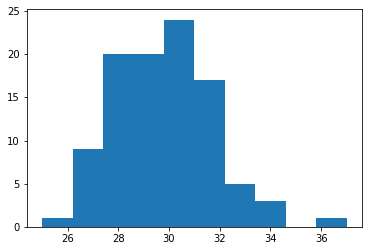

In [118]:
plt.hist([estimator.tree_.max_depth for estimator in rf.estimators_])
# usual depth for min_samples_leaf is around 40-45
#min_weight_fraction_leave of 1e-3 gives depth of 18
#min_weight_fraction_leaf of 1e-4 gives depth of 30-32
#nin_weight_fraction_leaf of 1e-5 gives depth of 35-45

In [20]:
if False:
    print("PCA model, test results:")
    for i in np.unique(test_cats):
        arr = test_cats==i
        test_features_i = rot_norm_pcs_test[arr]
        test_cats_i = test_cats[arr]
        sc = rf.score(test_features_i, test_cats_i)
        freq_of_type = np.sum(arr)/len(arr)
        print(f'score for {labels[i]} ({freq_of_type:0.0%}):      {sc:0.0%}')

    sc = rf.score(rot_norm_pcs_test, test_cats)
    print(f'\nOverall score:      {sc:0.0%}')


In [96]:
# Extra Random Tree model for the PC-transformed data
rf_extra = ExtraTreesClassifier(**rf_params)
# Train the model on training data
rf_extra.fit(rot_norm_pcs, train_cats)
#model accuracy per category
print("PCA model:")
for i in np.unique(val_cats):
    arr = val_cats==i
    val_features_i = rot_norm_pcs_val[arr]
    val_cats_i = val_cats[arr]
    sc = rf_extra.score(val_features_i, val_cats_i)
    freq_of_type = np.sum(arr)/len(arr)
    print(f'score for {labels[i]} ({freq_of_type:0.0%}):      {sc:0.0%}')
    
sc = rf_extra.score(rot_norm_pcs_val, val_cats)
print(f'\nOverall score:      {sc:0.0%}')

sc = rf_extra.score(rot_norm_pcs, train_cats)
print(f'\nTraining score:      {sc:0.0%}')

PCA model:
score for Closed-cellular MCC (12%):      62%
score for Clustered cumulus (32%):      38%
score for Disorganized MCC (19%):      45%
score for Open-cellular MCC (3%):      53%
score for Solid Stratus (10%):      62%
score for Suppressed Cu (24%):      57%

Overall score:      50%

Training score:      54%


In [28]:
# this is a second model, trained with the regular unscaled, un-PCA'd training data
rf_npc = RandomForestClassifier(**rf_params)
# Train the model on training data
rf_npc.fit(train_features, train_cats)
#model accuracy per category
print("NON-PCA model:")
for i in np.unique(test_cats):
    arr = test_cats==i
    test_features_i = test_features[arr]
    test_cats_i = test_cats[arr]
    sc = rf_npc.score(test_features_i, test_cats_i)
    print(f'score for {labels[i]}:      {sc:0.0%}')
    
sc = rf_npc.score(test_features, test_cats)
print(f'\nOverall score:      {sc:0.0%}')

NON-PCA model:
score for Closed-cellular MCC:      65%
score for Clustered cumulus:      61%
score for Disorganized MCC:      56%
score for Open-cellular MCC:      25%
score for Solid Stratus:      53%
score for Suppressed Cu:      54%

Overall score:      57%


# Part 3: Feature importance, Partial Dependencies

In [ ]:
feat_import_npc = permutation_importance(rf_npc, test_features, test_cats, n_jobs=4)
feat_import = permutation_importance(rf, rot_norm_pcs_test, test_cats, n_jobs=4)

In [37]:
def feature_importance_by_category(model, test_features, test_cats):
    cat_dict = {}
    for i in np.unique(test_cats):
        arr = test_cats==i
        test_features_i = test_features[arr]
        test_cats_i = test_cats[arr]
        pfi = permutation_importance(model, test_features_i, test_cats_i, n_jobs=4)
        cat_dict[i] = pfi
    return cat_dict
# feat_import_npc_by_cat = feature_importance_by_category(rf_npc, test_features, test_cats)
# feat_import_by_cat = feature_importance_by_category(rf, rot_norm_pcs_test, test_cats)


/home/disk/p/jkcm/anaconda3/envs/classified-cset/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


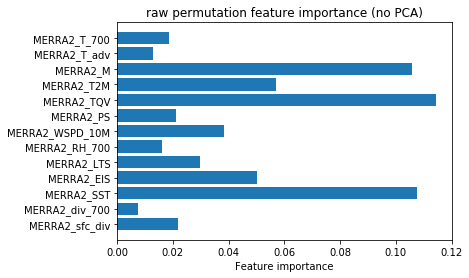

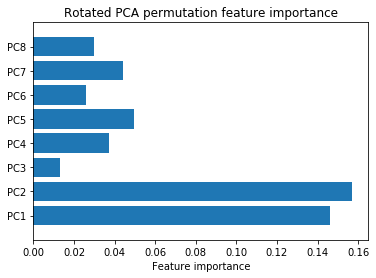

In [51]:
def plot_pfi(vals, labs, title='', ax=None):
    if not ax:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure
    ax.barh(range(len(vals)), vals, align='center')
    ax.set_yticks(np.arange(len(vals)))
    ax.set_yticklabels(labs)
    ax.set_xlabel("Feature importance")
    ax.set_label("Feature")
    ax.set_ylim(-1, len(vals))
    ax.set_title(title)
    return fig, ax

fig, ax = plot_pfi(feat_import_npc['importances_mean'], vars_to_use, 'raw permutation feature importance (no PCA)')
fig, ax = plot_pfi(feat_import['importances_mean'], [f'PC{i+1}' for i in range(k)], 'Rotated PCA permutation feature importance')

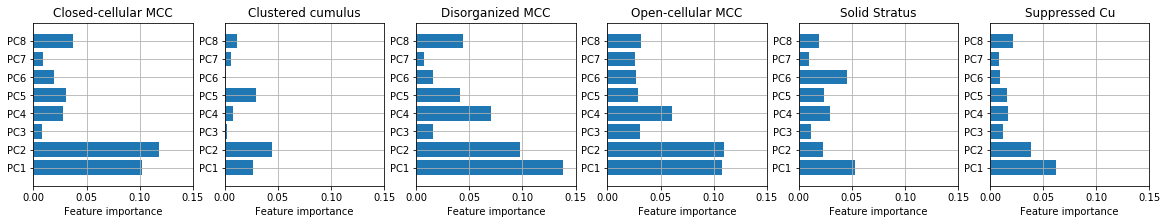

In [57]:
fig, ax = plt.subplots(ncols=6, figsize=(20,3))
for axi, key in zip(ax, list(feat_import_by_cat.keys())):
    plot_pfi(feat_import_by_cat[key]['importances_mean'], [f'PC{i+1}' for i in range(k)], labels[int(key)], ax=axi)
for axi in ax:
    axi.grid(True)
    axi.set_xlim((0, 0.15))

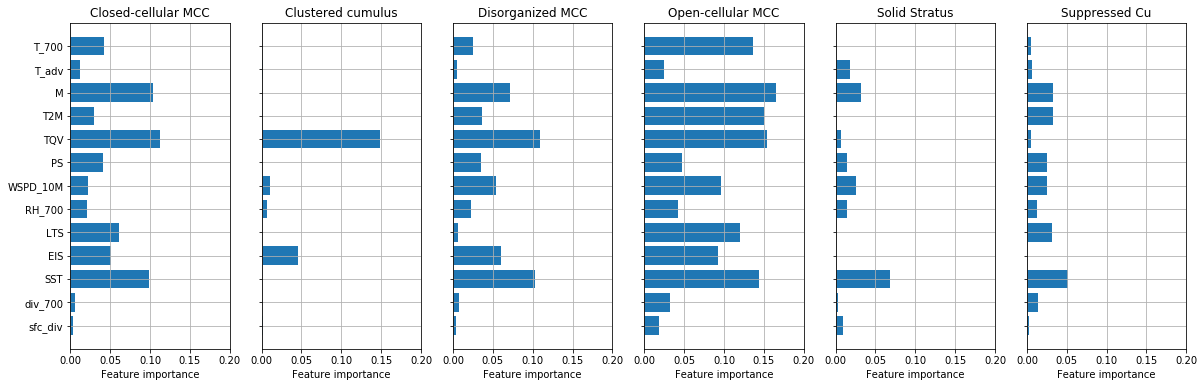

In [64]:
fig, ax = plt.subplots(ncols=6, figsize=(20,6), sharey=True)
for axi, key in zip(ax, list(feat_import_by_cat.keys())):
    plot_pfi(feat_import_npc_by_cat[key]['importances_mean'], [i[7:] for i in vars_to_use], labels[int(key)], ax=axi)
for axi in ax:
    axi.grid(True)
    axi.set_xlim((0, 0.2))

In [18]:
model_save_dict = dict(
    model=rf,
    x_test = rot_norm_pcs_test,
    x_train = rot_norm_pcs,
    loadings =rot_loadings,
    pct_var = pct_var,
    pct_var_rot = pct_var_rot)

pickle.dump(model_save_dict, open(f'/home/disk/eos4/jkcm/Data/MEASURES/models/simple_rf_pca_model.pickle', "wb" ))


In [19]:
# This is a very computationally intensive calculation, and should be batched out and done on a separate node, to avoid clogging the main fileserver

for target in rf.classes_:
    break
#     pdp = plot_partial_dependence(rf, rot_norm_pcs_test, features=[0, 1, 2, 3, 4, 5, 6, 7], feature_names=[f'PC{i+1}' for i in range(loadings.shape[0])], 
#                             target=target, verbose=True, n_jobs=4)
    pdp_2d = plot_partial_dependence(rf, rot_norm_pcs_test, features=[(0,1), (0,4), (2,6)], feature_names=[f'PC{i+1}' for i in range(loadings.shape[0])], 
                            target=target, verbose=True, n_jobs=4)
    pickle.dump(pdp, open(f'/home/disk/eos4/jkcm/Data/MEASURES/pdp/ver1_pdp_target_2d_{target}.pickle', "wb" ))

# for target in rf.classes_

# Part 4: What if we did a regression instead?

In [ ]:
# rf_r = RandomForestRegressor(

In [26]:
corr = train_subset[train_subset.lat>-50].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,MERRA2_sfc_div,MERRA2_div_700,MERRA2_SST,MERRA2_EIS,MERRA2_LTS,MERRA2_RH_700,MERRA2_WSPD_10M,MERRA2_PS,MERRA2_TQV,MERRA2_T2M,MERRA2_M,MERRA2_T_adv,MERRA2_T_700,low_cf,cat,lat
MERRA2_sfc_div,1.00,-0.41,-0.15,0.31,0.22,-0.23,0.03,0.16,-0.30,-0.16,-0.18,-0.16,-0.03,-0.09,0.09,-0.11
MERRA2_div_700,-0.41,1.00,0.18,-0.22,-0.09,0.25,-0.15,-0.14,0.33,0.20,0.08,0.22,0.13,0.03,0.02,0.15
MERRA2_SST,-0.15,0.18,1.00,-0.44,-0.11,0.03,-0.24,-0.50,0.74,0.99,0.14,0.00,0.82,-0.40,0.17,0.87
MERRA2_EIS,0.31,-0.22,-0.44,1.00,0.84,-0.53,0.06,0.42,-0.65,-0.46,-0.55,-0.17,0.04,0.32,-0.20,-0.40
MERRA2_LTS,0.22,-0.09,-0.11,0.84,1.00,-0.37,-0.11,0.19,-0.25,-0.10,-0.79,-0.09,0.45,0.30,-0.14,-0.05
MERRA2_RH_700,-0.23,0.25,0.03,-0.53,-0.37,1.00,-0.07,-0.24,0.56,0.05,0.08,0.10,-0.14,0.09,0.04,0.13
MERRA2_WSPD_10M,0.03,-0.15,-0.24,0.06,-0.11,-0.07,1.00,-0.08,-0.24,-0.21,0.06,-0.13,-0.24,0.21,-0.11,-0.19
MERRA2_PS,0.16,-0.14,-0.50,0.42,0.19,-0.24,-0.08,1.00,-0.55,-0.54,-0.05,-0.04,-0.43,0.18,-0.12,-0.64
MERRA2_TQV,-0.30,0.33,0.74,-0.65,-0.25,0.56,-0.24,-0.55,1.00,0.76,0.11,0.12,0.56,-0.19,0.13,0.75
MERRA2_T2M,-0.16,0.20,0.99,-0.46,-0.10,0.05,-0.21,-0.54,0.76,1.00,0.09,0.05,0.83,-0.40,0.18,0.88


# A very simple model

In [91]:
vars_to_use = ['MERRA2_sfc_div', 'MERRA2_div_700', 'MERRA2_SST', 'MERRA2_EIS', 'MERRA2_LTS', 'MERRA2_RH_700', 
               'MERRA2_WSPD_10M', 'MERRA2_PS', 'MERRA2_TQV', 'MERRA2_T2M', 'MERRA2_M', 'MERRA2_T_adv', 'MERRA2_T_700']  # these are the variables to train on
train_subset = all_sep_df[vars_to_use + ['low_cf', 'cat', 'lat']].copy()  # including two different y variables.
train_subset.loc[np.abs(train_subset['MERRA2_T_adv'].values*86400)>5, 'MERRA2_T_adv'] = np.nan
train_subset = train_subset.dropna(axis='index')

labels={0: 'Closed-cellular MCC', 1: 'Clustered cumulus', 2: 'Disorganized MCC',
        3: 'Open-cellular MCC', 4: 'Solid Stratus', 5: 'Suppressed Cu'}

subset_categories = [0,3]
if subset_categories:
    train_subset = train_subset[[i in subset_categories for i in train_subset['cat']]]
    labels = {k: v for k, v in labels.items() if k in subset_categories}
    
train_subset = train_subset[train_subset.lat>-30]
    
    
subset_vars = ['MERRA2_EIS', 'MERRA2_T_700']
subset_labels = ['EIS', 'T$_{700}$']
    # Split the data into training and validation sets - since we have a separate test set, we can look at these all we want.
x_data = train_subset[subset_vars].values.copy()
y_data = train_subset['low_cf'].values.copy()
strat_data = train_subset['cat'].values.copy()  # this is the stratification variable - lets make sure we have the right amount of each category in both datasets.
simple_train_features, simple_test_features, simple_train_labels, simple_test_labels, simple_train_cats, simple_test_cats = train_test_split(
    x_data, y_data, strat_data, test_size = 0.25, random_state = 42, stratify=strat_data)

/home/disk/p/jkcm/anaconda3/envs/classified-cset/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


In [94]:
# model for the PC-transformed data
dtc = DecisionTreeClassifier(max_depth=1, splitter='best', class_weight='balanced')
# Train the model on training data
dtc.fit(simple_train_features, simple_train_cats)
#model accuracy per category
print("decision tree model:")
for i in np.unique(simple_test_cats):
    arr = simple_test_cats==i
    test_features_i = simple_test_features[arr]
    test_cats_i = simple_test_cats[arr]
    sc = dtc.score(test_features_i, test_cats_i)
    freq_of_type = np.sum(arr)/len(arr)
    print(f'score for {labels[i]} ({freq_of_type:0.0%}):      {sc:0.0%}')
    
sc = dtc.score(simple_test_features, simple_test_cats)
print(f'\nOverall score:      {sc:0.0%}')

if False:
    scores = cross_val_score(rf, x_all, strat_data, cv=5)

decision tree model:
score for Closed-cellular MCC (78%):      60%
score for Open-cellular MCC (22%):      70%

Overall score:      62%


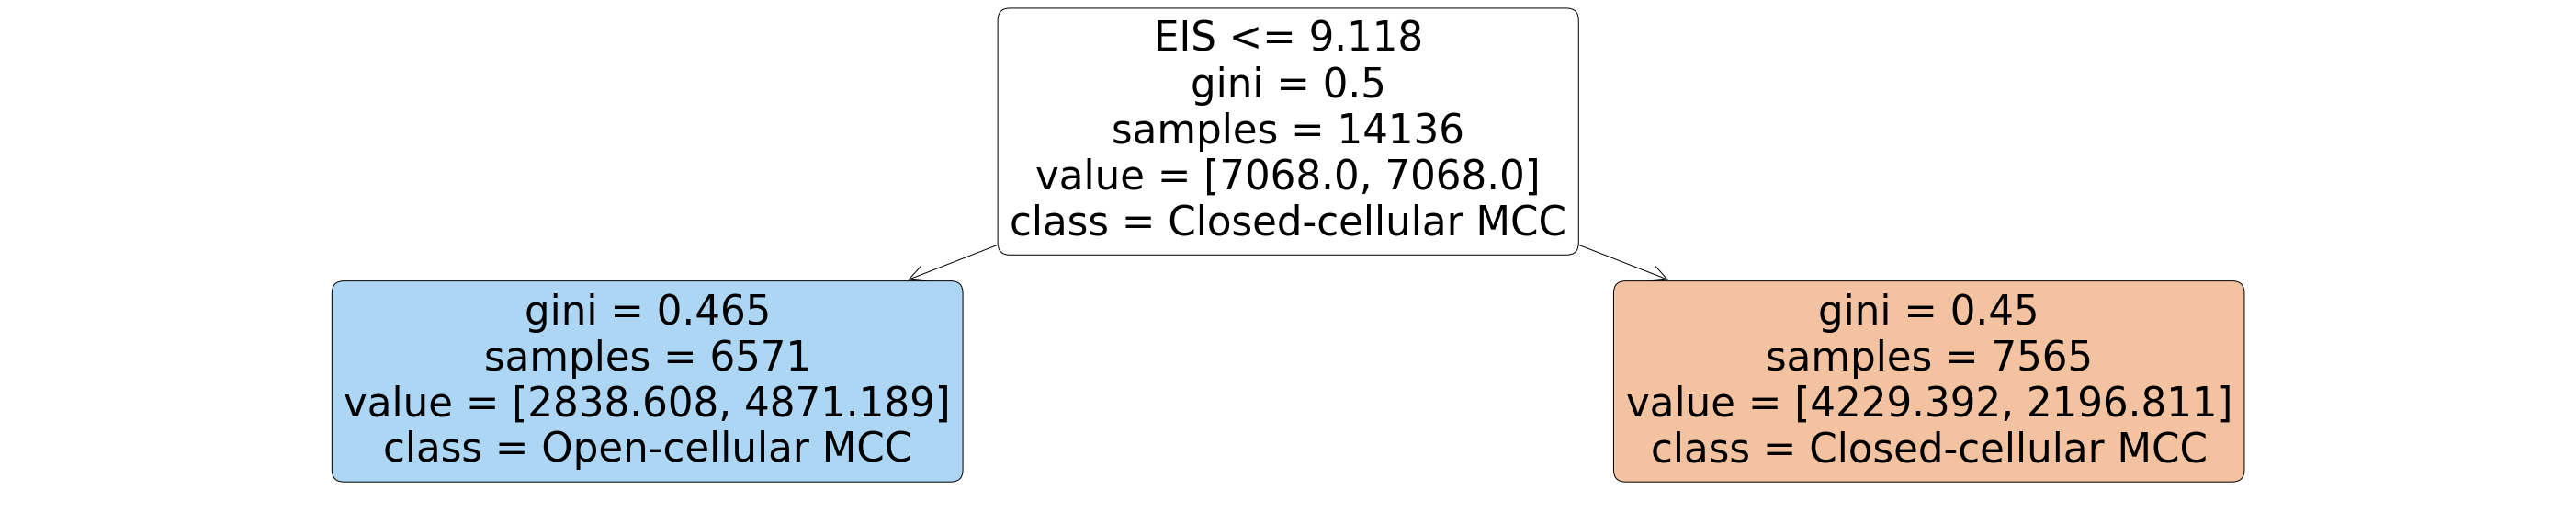

In [95]:
fig, ax = plt.subplots(figsize=(50,10))

plot_tree(dtc,
          feature_names = subset_labels, 
          class_names=[labels[i] for i in dtc.classes_],
          rounded=True,
          
          filled = True, ax=ax);